(288, 288, 3)


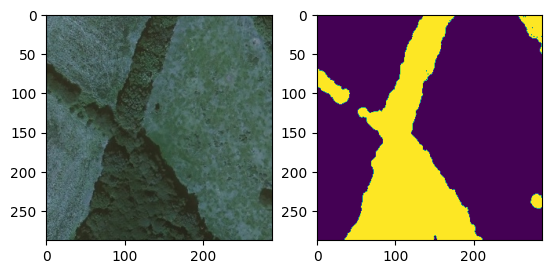

In [1]:
import imageio
import imgaug as ia
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import warnings
warnings.simplefilter("ignore")


image = imageio.imread("vignettes/rgb/rgb_305_6780/rgb_35_305000_6780000.jpg")
mask = imageio.imread("vignettes/mask/mask_305_6780/mask_35_305000_6780000.png")
print(image.shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image)
ax2.imshow(mask)

In [2]:
# change dtype from int64 to int32, as int32 is the allowed maximum in SegmentationMapsOnImage
segmap = (mask/255).astype(np.int32)

# draw statistics about our segmentation map
print("Shape:", segmap.shape, "min value:", segmap.min(), "max value:", segmap.max())

Shape: (288, 288) min value: 0 max value: 1


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
# Read an image from a file\n",
image_string = tf.io.read_file("vignettes/mask/mask_305_6780/mask_35_305000_6780000.png")
# Decode it into a dense vector\n",
image_decoded = tf.image.decode_jpeg(image_string, channels=3)
# Resize it to fixed shape
image_resized = tf.image.resize(image_decoded, [288, 288])
# Normalize it from [0, 255] to [0.0, 1.0]
image_normalized = image_resized / 255.0

data_augmentation = tf.keras.Sequential([
layers.RandomFlip(mode="horizontal_and_vertical"),
layers.RandomRotation(factor=0.2)])

image_augmented1 = data_augmentation(image_normalized)

In [13]:
# Read an image from a file\n",
image_string = tf.io.read_file("vignettes/rgb/rgb_305_6780/rgb_35_305000_6780000.jpg")
# Decode it into a dense vector\n",
image_decoded = tf.image.decode_jpeg(image_string, channels=3)
# Resize it to fixed shape
image_resized = tf.image.resize(image_decoded, [288, 288])
# Normalize it from [0, 255] to [0.0, 1.0]
image_normalized = image_resized / 255.0

data_augmentation = tf.keras.Sequential([
layers.RandomFlip(mode="horizontal_and_vertical"),
layers.RandomRotation(factor=0.2)])

image_augmented1 = data_augmentation(image_normalized)

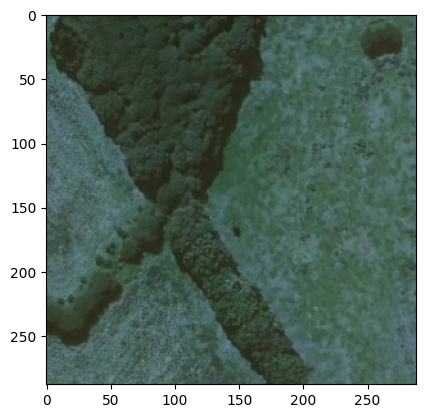

In [14]:
plt.imshow(image_augmented1)

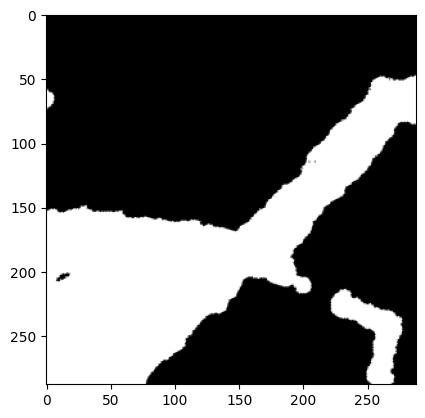

In [18]:
plt.imshow(image_augmented1)

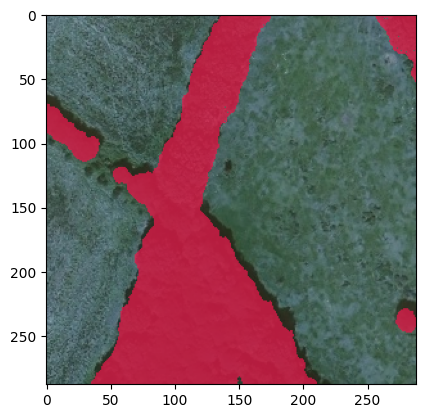

In [6]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

# convert array to SegmentationMapsOnImage instance
segmap = SegmentationMapsOnImage(segmap, shape=image.shape)

# visualize
# Note that the segmentation map drawing methods return lists of RGB images.
# That is because the segmentation map may have multiple channels
# -- the C in (H,W,C) -- and one image is drawn for each of these channels.
# We have C=1 here, so we get a list of a single image here and acces that via [0].
plt.imshow(segmap.draw_on_image(image)[0])

In [7]:
import imgaug.augmenters as iaa
ia.seed(2)

seq = iaa.Sequential([
    iaa.CoarseDropout(0.1, size_percent=0.2),
    # iaa.Affine(rotate=(-30, 30)),
    iaa.ElasticTransformation(alpha=10, sigma=1)
])


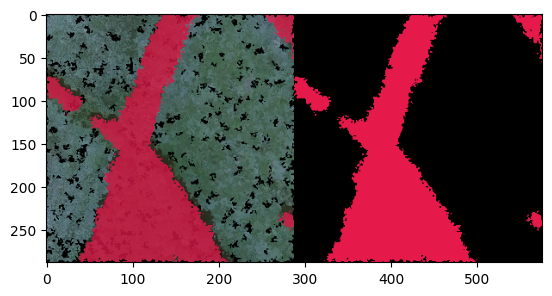

In [8]:
image_aug, segmap_aug = seq(image=image, segmentation_maps=segmap)

# visualize
plt.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug)[0],  # show blend of (augmented) image and segmentation map
    segmap_aug.draw()[0]  # show only the augmented segmentation map
]))


In [9]:
aug = iaa.ElasticTransformation(alpha=200, sigma=10)

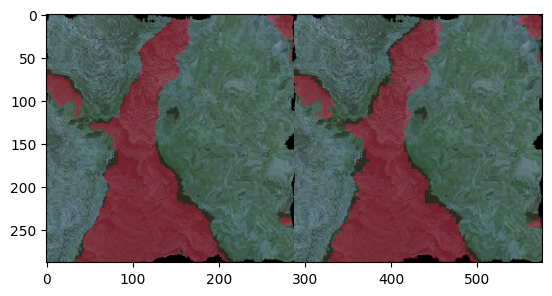

In [11]:
segmap_small = segmap.resize(0.25)

aug_det = aug.to_deterministic()
image_aug = aug_det.augment_image(image)  # augment image
segmap_aug = aug_det.augment_segmentation_maps(segmap)  # augment normal-sized segmentation map
segmap_small_aug = aug_det.augment_segmentation_maps(segmap_small)  # augment smaller-sized segmentation map

plt.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug, alpha=0.4)[0],  # draw augmented normal-sized segmentation map
    segmap_small_aug.draw_on_image(image_aug, alpha=0.4)[0]  # draw augmented smaller-sized segmentation map
]))

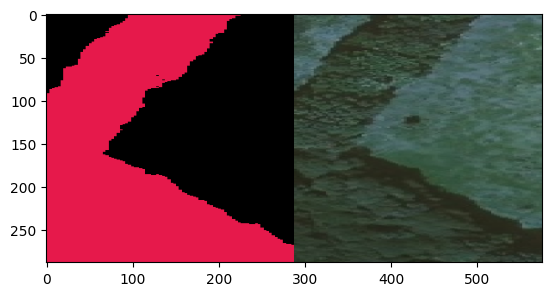

In [12]:
aug = iaa.Crop(px=(10, 100, 25, 100), keep_size=True)  # (top, right, bottom, left)

# We have to augment two segmentation maps with the exactly same random values.
# This is why we switch to deterministic mode here, which resets the random state after
# each augmentation.
# (Due to using non-stochastic crop values, we could also skip this, but it seems cleaner
# to do it.)
aug_det = aug.to_deterministic()
image_aug = aug_det.augment_image(image)  # augment image
segmap_aug = aug_det.augment_segmentation_maps(segmap)  # augment normal-sized segmentation map
segmap_small_aug = aug_det.augment_segmentation_maps(segmap_small)  # augment smaller-sized segmentation map

plt.imshow(np.hstack([
    segmap_aug.draw()[0],  # draw augmented normal-sized segmentation map
    image_aug
]))
